In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. 데이터 전처리

In [ ]:
import os
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from transformers import BertTokenizerFast
import tensorflow as tf

# 한국어 질의응답(Question Answering) 데이터셋인 KorQuad데이터 다운
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json -O KorQuAD_v1.0_train.json
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json -O KorQuAD_v1.0_dev.json

--2023-04-13 07:15:27--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘KorQuAD_v1.0_train.json’

KorQuAD_v1.0_train. 100%[===================>]  36.74M   134MB/s    in 0.3s    

2023-04-13 07:15:27 (134 MB/s) - ‘KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2023-04-13 07:15:28--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: ‘KorQuAD_v1.0_dev.json’

KorQuAD_v1.0_dev.js 100%[======

데이터를 본문, 질문, 답변으로 분리해 로드

In [ ]:
def read_squad(path):
  path = Path(path)
  with open(path, 'rb') as f:
    squad_dict = json.load(f)
    
  contexts = []
  questions = []
  answers = []
  for group in squad_dict['data']:
    for passage in group['paragraphs']:
      context = passage['context'] 
      for qa in passage['qas']:
        question = qa['question'] 
        for answer in qa['answers']:
          contexts.append(context)
          questions.append(question)
          answers.append(answer)
  return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('KorQuAD_v1.0_train.json')
val_contexts, val_questions, val_answers = read_squad('KorQuAD_v1.0_dev.json')

print('훈련 데이터의 본문 개수 :', len(train_contexts))
print('훈련 데이터의 질문 개수 :', len(train_questions))
print('훈련 데이터의 답변 개수 :', len(train_answers))
print('테스트 데이터의 본문 개수 :', len(val_contexts))
print('테스트 데이터의 질문 개수 :', len(val_questions))
print('테스트 데이터의 답변 개수 :', len(val_answers))

훈련 데이터의 본문 개수 : 60407
훈련 데이터의 질문 개수 : 60407
훈련 데이터의 답변 개수 : 60407
테스트 데이터의 본문 개수 : 5774
테스트 데이터의 질문 개수 : 5774
테스트 데이터의 답변 개수 : 5774


In [ ]:
print('첫번째 샘플의 본문')
print('-----------------')
print(train_contexts[0])

첫번째 샘플의 본문
-----------------
1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.


In [ ]:
print('첫번째 샘플의 질문')
print('-----------------')
print(train_questions[0])

첫번째 샘플의 질문
-----------------
바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?


In [ ]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54}


train_answer에서는 본문의 정답 위치인 시작 인덱스는 없는데 종료 인덱스는 없다. 종료 인덱스를 추가해주자.

In [ ]:
def add_end_idx(answers, contexts):
  for answer, context in zip(answers, contexts):
    # 뒤에 공백이 있다면 제거.ex)'1990년대 '->'1990년대'
    answer['text'] = answer['text'].rstrip()
    #시작 인덱스에 정답의 길이를 더하여 종료 인덱스 계산
    gold_text = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(gold_text)
    assert context[start_idx:end_idx] == gold_text, "end_index 계산에 에러가 있습니다."
    answer['answer_end'] = end_idx

In [ ]:
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54, 'answer_end': 57}


In [ ]:
train_contexts[0][54:57]

'교향곡'

토크나이저에 본문과 질문을 입력해줍니다.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')
train_encodings = tokenizer(train_contexts, train_questions, truncation=True,
                            padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

[CLS] 이후에는 본문이 토큰화된 결과가 나옴 

[SEP] 토큰으로 본문이 끝났을을 알려줌 

-> 그 뒤에 질문에도 똑같이 적용
-> 문장이 끝나면 최대 길이까지 [PAD] 토큰이 반복됨
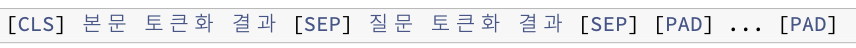

In [ ]:
print('첫번째 샘플의 토큰화 결과 :', train_encodings[0].tokens)

첫번째 샘플의 토큰화 결과 : ['[CLS]', '183', '##9', '##년', '바그너', '##는', '괴테', '##의', '파우', '##스트', '##을', '처음', '읽', '##고', '그', '내용', '##에', '마음', '##이', '끌려', '이를', '소재', '##로', '해서', '하나', '##의', '교향곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는', '##다', '.', '이', '시기', '바그너', '##는', '183', '##8', '##년', '##에', '빛', '독촉', '##으로', '산전', '##수', '##전', '##을', '다', '[UNK]', '상황', '##이', '##라', '좌절', '##과', '실망', '##에', '가득', '##했', '##으며', '메', '##피스', '##토', '##펠', '##레스', '##를', '만나', '##는', '파우', '##스트', '##의', '심경', '##에', '공감', '##했', '##다고', '한다', '.', '또한', '파리', '##에서', '아', '##브', '##네', '##크', '##의', '지휘', '##로', '파리', '음악', '##원', '관현', '##악단', '##이', '연주', '##하', '##는', '베토벤', '##의', '교향곡', '9', '##번', '##을', '듣', '##고', '깊', '##은', '감명', '##을', '받', '##았', '##는데', ',', '이것', '##이', '이듬해', '1', '##월', '##에', '파우', '##스트', '##의', '서', '##곡', '##으로', '쓰여진', '이', '작품', '##에', '조금', '##이', '##라도', '영향', '##을', '끼쳤', '##으리', '##라는', '것', '##은', '의심', '##할', '여지', '##가', '없', '##다', '.

In [ ]:
print('첫번째 샘플의 길이 :', len(train_encodings[0].tokens))

첫번째 샘플의 길이 : 512


BERT에서 입력을 받을 수 있는 최대 길이가 512. 이보다 길 경우 본문이 잘리고, 이보다 작은 경우에는 뒤에 [PAD]를 추가한다.

In [ ]:
# 첫 번째 샘플의 정수 인코딩 결과를 보자
print('첫번째 샘플의 정수 인코딩 :', train_encodings[0].ids)

첫번째 샘플의 정수 인코딩 : [2, 13934, 2236, 2440, 27982, 2259, 21310, 2079, 11994, 3791, 2069, 3790, 1508, 2088, 636, 3800, 2170, 3717, 2052, 9001, 8345, 4642, 2200, 3689, 3657, 2079, 19282, 2069, 1363, 2370, 2259, 936, 2069, 554, 2259, 2062, 18, 1504, 4342, 27982, 2259, 13934, 2196, 2440, 2170, 1195, 23260, 6233, 17370, 2113, 2165, 2069, 809, 1, 3706, 2052, 2181, 8642, 2145, 7334, 2170, 4983, 2371, 4007, 1065, 5917, 2386, 2559, 4443, 2138, 4026, 2259, 11994, 3791, 2079, 15864, 2170, 5487, 2371, 4683, 3605, 18, 3819, 5986, 27135, 1376, 2645, 2203, 2292, 2079, 5872, 2200, 5986, 4152, 2252, 22835, 16706, 2052, 5485, 2205, 2259, 17087, 2079, 19282, 29, 2517, 2069, 881, 2088, 652, 2073, 23404, 2069, 1122, 2886, 13964, 16, 3982, 2052, 9944, 21, 2429, 2170, 11994, 3791, 2079, 1258, 2465, 6233, 24294, 1504, 3967, 2170, 4027, 2052, 5121, 3979, 2069, 18274, 21575, 23548, 575, 2073, 5292, 2085, 7251, 2116, 1415, 2062, 18, 3776, 2079, 942, 2286, 2446, 4196, 2079, 3640, 6509, 636, 2079, 4450, 2170, 10329, 1

In [ ]:
# 실제 단어의 위치에는 1, [PAD]의 위치에는 0이 들어감
print('첫번째 샘플의 어텐션 마스크 :', train_encodings[0].attention_mask)

첫번째 샘플의 어텐션 마스크 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  deleting_list = []
  for i in tqdm(range(len(answers))):
    #char_to_token모듈 : 토큰화 전 문자의 인덱스(start,end)로부터 토큰화한 후의 문자의 인덱스(start, end)를 찾아냄. 
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1)) #answer_end에서 1뺀 값을 입력
    #시작 인덱스가 비정상인 경우.즉,본문에 정답이 없는 경우
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      deleting_list.append(i)
      #종료 인덱스가 비정상인 경우.즉,본문에 정답이 없는 경우
      if end_positions[-1] is None:
        end_positions[-1] = tokenizer.model_max_length 
        if i not in deleting_list:
          deleting_list.append(i)
          
  encodings.update({'start_positions': start_positions, 'end_positions':end_positions})
  return deleting_list

In [ ]:
# 삭제될 데이터셋
deleting_list_for_train = add_token_positions(train_encodings, train_answers)
deleting_list_for_test = add_token_positions(val_encodings, val_answers)

100%|██████████| 5774/5774 [00:00<00:00, 307189.66it/s]


In [ ]:
# 본문에 정답이 없는 샘플 확인
print('삭제 예정인 훈련 샘플 :', deleting_list_for_train)
print('삭제 예정인 테스트 샘플 :', deleting_list_for_test)

삭제 예정인 훈련 샘플 : [711, 726, 728, 729, 761, 765, 767, 768, 805, 2586, 2587, 2722, 2724, 2725, 2731, 3475, 3491, 3495, 3498, 3919, 4462, 4465, 4513, 4515, 4565, 4765, 4766, 4772, 4774, 4779, 5334, 6603, 6638, 6639, 6748, 6749, 6750, 6765, 6766, 6771, 6776, 6897, 6898, 6900, 7739, 7741, 9203, 9211, 10880, 11039, 11212, 11727, 11776, 11788, 11789, 11791, 12168, 13708, 13711, 14460, 14461, 14491, 14724, 14729, 15764, 15970, 15971, 15973, 15974, 15976, 15977, 15979, 15980, 16080, 17683, 17815, 17828, 18389, 18392, 19045, 19052, 19053, 19195, 19636, 19637, 19638, 19640, 19656, 19761, 19764, 19765, 20614, 20618, 21224, 21243, 21335, 21338, 21361, 21521, 21522, 22627, 24003, 24577, 24579, 24580, 24768, 25108, 25176, 25185, 25186, 25187, 25188, 25448, 25451, 25454, 25457, 25460, 27105, 27112, 27113, 27114, 27159, 27293, 27295, 27555, 27558, 28025, 28779, 29162, 29189, 29289, 29290, 31889, 31890, 31891, 31894, 31905, 32050, 32051, 32057, 32058, 32059, 32088, 32431, 32436, 32477, 33134, 33135, 33293

실제로 본문에 정답이 없는지 '삭제 예정인 훈련 샘플' 중 하나를 확인해보자

In [ ]:
print('761번 샘플의 질문 :',train_questions[761])
print('-'*50)
print('761번 샘플의 기존 원문 :',train_contexts[761])

761번 샘플의 질문 : 소치 팀추월 파이널D에서 여자 팀추월 대표팀의 최종 성적은?
--------------------------------------------------
761번 샘플의 기존 원문 : 2014년 2월 9일 러시아 소치 아들레르 아레나서 열린 소치 동계올림픽 3000m 부문에서 김보름(21)은 4분12초08의 기록으로로 13위를 차지했다. 이날 3조로 경기를 치른 김보름은 21초05로 200m 구간을 통과한 후 2분31초34로 1800m 구간을 지났다. 이후 2200m 구간 통과 순간부터 스피드를 올리며 후반 들어 스퍼트를 올렸고, 결국 하위권이 아닌 중위권 기록을 남겼다. 김보름의 순위인 13위는 지난 2006 토리노 올림픽, 2010 밴쿠버 올림픽 당시 노선영(25-강원도청)이 기록한 19위를 넘어 한국 여자 3000m 부문의 가장 높은 순위다. 5조의 노선영은 4분19초02를 기록했다. 노선영은 200m 구간에서 21초32의 기록으로 지난 이후 속도를 올리지 못한 채로 결승점을 통과했다. 결국 노선영은 전체 26위의 성적을 남기며 경기를 마쳤다. 6조에서 경기를 소화한 양신영(24-전북도청)은 4분23초67을 기록해 이날 대회를 뛴 28명 중 최저의 기록을 남겼다. 한편 이날 대회는 4분00초34의 이레네 부스트(네덜란드)가 2006년 토리노 동계올림픽 이후 8년 만에 금메달을 다시 가져갔다. 대회 2연패를 노린 2위 마르티나 사블리코바(체코-4분01초95)와 3위 올가 그라프(러시아-4분03초47)에 앞선 기록이다. 16일 열린 1500m에서는 네덜란드의 요리엔 테르모르스가 1분53초51의 올림픽 기록으로 금메달을 차지했다. 은메달과 동메달도 네덜란드 선수들이 휩쓸었다. 은메달은 이레인 뷔스트(1분54초09)에게 돌아갔고 동메달은 하를로터 판바이크(1분54초54)가 주인이 됐다. 심지어 4위도 네덜란드 선수인 마리트 리엔스트라(1분56초40)가 차지했다. 김보름은 1분59초78로 21위에 올랐다. 노선영(25-강원도청)은 2분01초

이 샘플의 정답 위치를 출력

In [ ]:
print('761번 샘플의 기존 정답 :', train_answers[761])

761번 샘플의 기존 정답 : {'text': '8위', 'answer_start': 1050, 'answer_end': 1052}


'8워' 라는 단어가 토큰화된 결과에 존재하는지 확인

In [ ]:
print('761번 샘플 전처리 후 :', tokenizer.decode(train_encodings['input_ids' ][761]))

761번 샘플 전처리 후 : [CLS] 2014년 2월 9일 러시아 소치 아들레르 아레나서 열린 소치 동계올림픽 3000m 부문에서 김보름 ( 21 ) 은 4분12초08의 기록으로로 13위를 차지했다. 이날 3조로 경기를 치른 김보름은 21초05로 200m 구간을 통과한 후 2분31초34로 1800m 구간을 지났다. 이후 2200m 구간 통과 순간부터 스피드를 올리며 후반 들어 스퍼트를 올렸고, 결국 하위권이 아닌 중위권 기록을 남겼다. 김보름의 순위인 13위는 지난 2006 토리노 올림픽, 2010 밴쿠버 올림픽 당시 노선영 ( 25 - 강원도청 ) 이 기록한 19위를 넘어 한국 여자 3000m 부문의 가장 높은 순위다. 5조의 노선영은 4분19초02를 기록했다. 노선영은 200m 구간에서 21초32의 기록으로 지난 이후 속도를 올리지 못한 채로 결승점을 통과했다. 결국 노선영은 전체 26위의 성적을 남기며 경기를 마쳤다. 6조에서 경기를 소화한 양신영 ( 24 - 전북도청 ) 은 4분23초67을 기록해 이날 대회를 뛴 28명 중 최저의 기록을 남겼다. 한편 이날 대회는 4분00초34의 이레네 부스트 ( 네덜란드 ) 가 2006년 토리노 동계올림픽 이후 8년 만에 금메달을 다시 가져갔다. 대회 2연패를 노린 2위 마르티나 사블리코바 ( 체코 - 4분01초95 ) 와 3위 올가 그라프 ( 러시아 - 4분03초47 ) 에 앞선 기록이다. 16일 열린 1500m에서는 네덜란드의 요리엔 테르모르스가 1분53초51의 올림픽 기록으로 금메달을 차지했다. 은메달과 동메달도 네덜란드 선수들이 휩쓸었다. 은메달은 이레인 뷔스트 ( 1분54초09 ) 에게 돌아갔고 동메달은 하를로터 판바이크 ( 1분54초54 ) 가 주인이 됐다. 심지어 4위도 네덜란드 선수인 마리트 리엔스트라 ( 1분56초40 ) 가 차지했다. 김보름은 1분59초78로 21위에 올랐다. 노선영 ( 25 - 강원도청 ) 은 2분01초07로 29위, 양신영 ( 24 - 전북도청 ) [SEP] 소치 팀추월 파이널D

본문 뒤가 잘렸기 때문에 '8위'라는 단어는 없다.
해당 샘플을 제거하는 함수를 만들자.



In [ ]:
def delete_samples(encodings, deleting_list):
  input_ids = np.delete(np.array(encodings['input_ids']), deleting_list, axis=0)
  attention_masks = np.delete(np.array(encodings['attention_mask']),
         deleting_list, axis=0)
  start_positions = np.delete(np.array(encodings['start_positions']),
         deleting_list, axis=0)
  end_positions = np.delete(np.array(encodings['end_positions']), deleting_list, axis=0)

  X_data = [input_ids, attention_masks]
  y_data = [start_positions, end_positions]

  return X_data, y_data

In [ ]:
X_train, y_train = delete_samples(train_encodings, deleting_list_for_train)
X_test, y_test = delete_samples(val_encodings, deleting_list_for_test)

In [ ]:
print('------------- 삭 제 전 -------------')
print('훈 련 데 이 터 의 샘 플 의 개 수 :', len(train_contexts))
print('테스트 데이터의 샘플의 개수 :',len(val_contexts))
print('------------- 삭 제 후 -------------')
print('훈련 데이터의 샘플의 개수 :',len(X_train[0]))
print('테스트 데이터의 샘플의 개수 :',len(X_test[0]))

------------- 삭 제 전 -------------
훈 련 데 이 터 의 샘 플 의 개 수 : 60407
테스트 데이터의 샘플의 개수 : 5774
------------- 삭 제 후 -------------
훈련 데이터의 샘플의 개수 : 60152
테스트 데이터의 샘플의 개수 : 5720


# 2. BERT 를 이용한 Question Answering

BERT가 입력받는 길이가 512개라면, 이 후보들 중에서 시작 인덱스를 예측하는 다중 클래스 분류 문제 + 이중 종료 인덱스를 예측하는 다중 클래스 분류 문제로 총 2가지 문제를 풀게 된다.

In [ ]:
from transformers import TFBertModel
class TFBertForQuestionAnswering(tf.keras.Model):
  def __init__(self, model_name):
    super(TFBertForQuestionAnswering, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)

    self.qa_outputs = tf.keras.layers.Dense(2, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                            name='qa_outputs')
    self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)

  def call(self, inputs):
    input_ids, attention_mask = inputs
    outputs = self.bert(input_ids, attention_mask=attention_mask)
    #BERT의 마지막 층의 모든 토큰들. 
    sequence_output = outputs[0]
    logits = self.qa_outputs(sequence_output)
    
    #사용할 출력층은 총2개.각각 시작 인덱스 예측과 종료 인덱스 예측에 사용된다.
    start_logits, end_logits = tf.split(logits, 2, axis=-1)
    
    # start_logits = (batch_size, sequence_length,)
    # end_logits = (batch_size, sequence_length,)
    start_logits = tf.squeeze(start_logits, axis=-1)
    end_logits = tf.squeeze(end_logits, axis=-1)
    
    # 시작 인덱스에 대한 다중클래스 분류문제
    start_probs = self.softmax(start_logits)
    # 종료 인덱스에 대한 다중클래스 분류문제 
    end_probs = self.softmax(end_logits)
    
    return start_probs, end_probs

In [ ]:
model = TFBertForQuestionAnswering("klue/bert-base")
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=[loss, loss])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
# X_train = np.array(X_train, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
history = model.fit(X_train, y_train, epochs=2, verbose=1, batch_size=16,)

Epoch 1/2


OperatorNotAllowedInGraphError: ignored

# 3. 테스트 데이터에 대한 예측

인덱스를 입력했을 때 해당 인덱스의 테스트 데이터 샘플을 모델에 넣고 결과를 출력하는 함수를 만들자.

In [ ]:
def predict_test_data_by_idx(idx):
  # 테스트 데이터의 idx번째 샘플의 본문, 질문, 정답을 출력
  context = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[0]
  question = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[1]
  print(' 본 문 :', context)
  print(' 질 문 :', question)
  answer_encoded = X_test[0][idx][y_test[0][idx]:y_test[1][idx]+1]
  print(' 정 답 :',tokenizer.decode(answer_encoded))

  output = model([tf.constant(X_test[0][idx])[None, :], tf.constant(X_test[1][idx])[None, :]])

  # 예측된 시작 인덱스와 종료 인덱스에 대한 값을 각각 start와 end에 저장.
  start = tf.math.argmax(tf.squeeze(output[0]))
  end = tf.math.argmax(tf.squeeze(output[1]))+1

  # 본문으로부터 예측된 '정답의 시작 인덱스'와 '종료 인덱스'를 통해 정답 추출
  answer_encoded = X_test[0][idx][start:end]
  print('예 측 :',tokenizer.decode(answer_encoded))
  print('----------------------------------------')

In [ ]:
# 0-99번 샘플의 결과를 출력해보자.
# 중간에 오류가 나서 예외처리를 해줬다.
for i in range(0, 100):
  try:
    predict_test_data_by_idx(i)
  except:
    pass

 본 문 : [CLS] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다. 
 질 문 : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은? 
 정 답 : 1989년 2월 15일
예 측 : ##를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다. [SEP] 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

# 더 긴 입력을 위해 모델을 바꿔보기

앞서 사용한 BERT는 길이가  512이상의 문서는 입력으로 받을 수 없습니다.

이번엔 4096 의 길이까지 입력을 받을 수 있는 박장원 (monologg) 님의 KoBigBird 모델을 사용하면 KorQuad 의 본문이 잘리는 일 없이 학습해보겠습니다.

In [ ]:
#변경된 토크나이저 코드.
tokenizer = BertTokenizerFast.from_pretrained('monologg/kobigbird-bert-base')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [ ]:
model = TFBertForQuestionAnswering("monologg/kobigbird-bert-base") 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
model.compile(optimizer=optimizer, loss=[loss, loss])